In [1]:
from pycaret.regression import *
import xarray as xr
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LogNorm
import warnings
import cmocean

pd.set_option('display.max_columns', None)
# Suppress all warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import shap
from glob import glob

#import rioxarray as rio
from rasterio.enums import Resampling
import rioxarray as rio

# Suppress the specific warning\
warnings.filterwarnings("ignore", category=UserWarning, message="bagging_*")
warnings.filterwarnings("ignore", category=UserWarning, message="feature_*")
import rioxarray
import cmocean

In [5]:
# Example colormaps
cmap1 = plt.cm.Blues
cmap2 = plt.cm.plasma
cmap3 = plt.cm.plasma

colors1 = cmap1(np.linspace(0.01, 1,250))
colors2 = cmap2(np.linspace(0.2, 1, 400))
colors3 = cmap3(np.linspace(0.8, 1, 100))

colors = np.vstack((colors1, colors2))

colors_pd = pd.DataFrame(colors)
colors_pd = colors_pd.rolling(window = 250, min_periods = 1).mean()
x = colors_pd.values
colors = np.vstack((colors_pd.values, colors3))
colors_pd = pd.DataFrame(colors)
colors_pd = colors_pd.rolling(window = 50, min_periods = 1).mean()
x = colors_pd.values
# colors3 = colors_pd.values

blended_cmap = LinearSegmentedColormap.from_list('blended_cmap', x)

## Figure 4

In [12]:
ds = xr.open_dataset('20170316_066.nc')
#ds = xr.open_dataset(f'/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/figures/SD_maps/20170316_066_shap.nc')
sd_insitu_all = xr.open_dataset('../../_1_in_situ_data/all_data_qc_final.nc')
sd_insitu = sd_insitu_all.sel(time = pd.Timestamp(2017,3,16))

In [13]:
SD_map = rioxarray.open_rasterio('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/training_testing/photogrammetry/SD_20170316.tif').mean(dim = 'band')
df_dest = ds.SD.rename({'lat': 'y', 'lon': 'x'}).transpose('y', 'x')
df_dest.rio.write_crs("EPSG:4326", inplace = True)
df_out = SD_map.rio.reproject_match(df_dest, resampling = Resampling.average)
df_out = df_out.where((df_out < 100)&(df_out >=0))
df_out = df_out.sel(y = slice(46.67,46.9), x = slice(9.65, 10.1)).rename({'y': 'lat', 'x': 'lon'})

ds_hans_1000 = xr.open_dataset('/staging/leuven/stg_00024/OUTPUT/hansl/S1_100m/MATLAB_proc_alps/OPER_SD_v2_4DMED/1000m/mosaic/snd_20170316.nc').transpose('lat','lon')
ds_hans_1000.rio.write_crs("EPSG:4326", inplace = True)
ds_hans_1000 = ds_hans_1000.snd.rename({'lat': 'y', 'lon': 'x'}).transpose('y', 'x')
ds_hans_1000 = ds_hans_1000.rio.reproject_match(df_dest)
ds_hans_1000 = ds_hans_1000.sel(y = slice(46.67,46.9), x = slice(9.65, 10.1))


ds_hans_100 = xr.open_dataset('/staging/leuven/stg_00024/OUTPUT/hansl/S1_100m/MATLAB_proc_alps/OPER_SD_v2_4DMED/100m/y035x200/snd_20170316.nc').transpose('lat','lon')
ds_hans_100.rio.write_crs("EPSG:4326", inplace = True)
ds_hans_100 = ds_hans_100.snd.rename({'lat': 'y', 'lon': 'x'}).transpose('y', 'x')
ds_hans_100 = ds_hans_100.rio.reproject_match(df_dest)
ds_hans_100 = ds_hans_100.sel(y = slice(46.67,46.9), x = slice(9.65, 10.1))
#ds = ds.sel(lat = slice(46.9,46.67), lon = slice(9.65, 10.1))


with open('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/OUTPUT/testing_output/predictions_s1_xg.p', 'rb') as fp:
    all_data = pickle.load(fp) 
    
all_data.loc[all_data.sc_per<0.25, 'prediction_label'] = 0

In [14]:
sd_map = np.copy(df_out.values)
sd_ml = np.copy(ds.SD.values)
sd_h1000 = np.copy(ds_hans_1000.values)
sd_h100 = np.copy(ds_hans_100.values)

sd_ml[np.isnan(sd_map)] = np.nan
sd_h1000[np.isnan(sd_map)] = np.nan
sd_h100[np.isnan(sd_map)] = np.nan

anom_map = sd_map - np.nanmean(sd_map)
anom_ml = sd_ml - np.nanmean(sd_ml)
anom_h1000 = sd_h1000 - np.nanmean(sd_h1000)
anom_h100 = sd_h100 - np.nanmean(sd_h100)

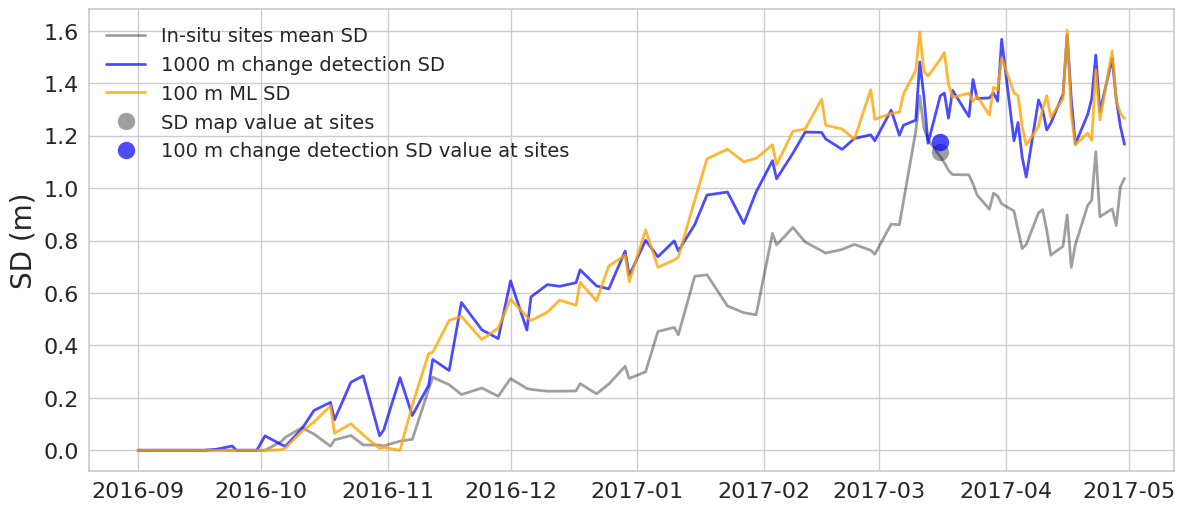

In [15]:
sites = sd_insitu.where((sd_insitu.lat>=46.67)&(sd_insitu.lat<=46.9)&(sd_insitu.lon>=9.65)&(sd_insitu.lon<=10.1)).lat.dropna(dim = 'site').site.values
sites2 = list()
h100_sd_sites, map_mean = list(), list()
for s in sites:
    slat = sd_insitu.sel(site=s).lat.values
    slon = sd_insitu.sel(site=s).lon.values
    map_sd_site = df_out.sel(lat = slat, lon = slon, method = 'nearest')
    if not np.isnan(map_sd_site.values):
        sites2.append(s)
        map_mean.append(float(map_sd_site.mean().values))
        h100_sd_site = ds_hans_100.sel(y = slat, x = slon, method = 'nearest')
        h100_sd_sites.append(float(h100_sd_site.mean().values))

data_s = all_data[(all_data.site.isin(sites2))&(all_data.time>pd.Timestamp(2016,8,1))&(all_data.time<pd.Timestamp(2017,5,1))]
timeseries = data_s.groupby(data_s.time).mean()


fig, ax = plt.subplots(1,1,figsize = (14,6))
ax.plot(timeseries.sd_insitu, 'k',alpha = 0.4, label = 'In-situ sites mean SD', linewidth = 2)
ax.plot(timeseries.sd_hans, color = 'blue',alpha = 0.7, label = '1000 m change detection SD', linewidth = 2)
ax.plot(timeseries.prediction_label, color = 'orange',alpha = 0.8, label = '100 m ML SD', linewidth = 2)
ax.plot([pd.Timestamp(2017,3,16)], [np.mean(map_mean)], 'k.', alpha = 0.4, markersize = 25, label = 'SD map value at sites')
ax.plot([pd.Timestamp(2017,3,16)], [np.mean(h100_sd_sites)], '.', alpha = 0.7, color = 'blue', markersize = 25, label = '100 m change detection SD value at sites')
ax.legend(fontsize = 14)
ax.tick_params(axis='x', labelsize=16)  # Font size for x-axis tick labels
ax.tick_params(axis='y', labelsize=16)  # Font size for y-axis tick labels
ax.set_ylabel('SD (m)', fontsize = 20)
plt.savefig('panels/Figure4a.png', dpi = 300, bbox_inches = 'tight')

In [16]:
map_date = timeseries.loc[pd.Timestamp(2017,3,16)]
print(f'ml error = {map_date.prediction_label - map_date.sd_insitu}')
print(f'map error = {np.mean(map_mean) - map_date.sd_insitu}')
print(f'hans1000 error = {map_date.sd_hans - map_date.sd_insitu}')
print(f'hans1000 error = {np.mean(h100_sd_sites) - map_date.sd_insitu}')

ml error = 0.37071549892425537
map error = 0.017781678300637482
hans1000 error = 0.23195302486419678
hans1000 error = 0.055283427238464355


In [17]:
ds_hans_1000 = ds_hans_1000.rename({'y':'lat','x':'lon'})
ds_hans_100 = ds_hans_100.rename({'y':'lat','x':'lon'})

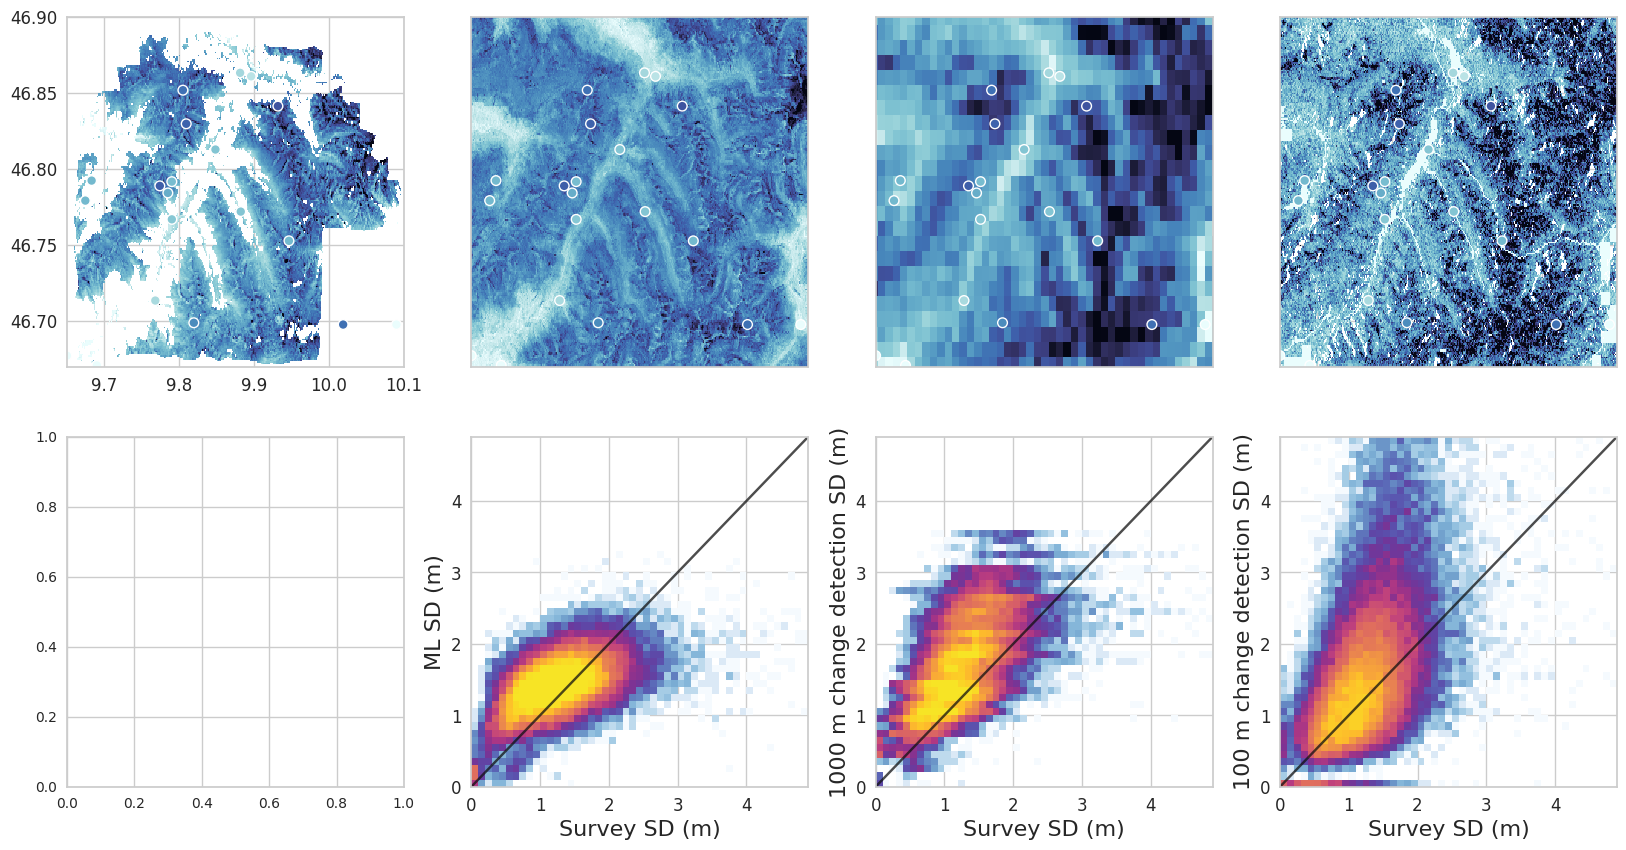

In [19]:
fig, ax = plt.subplots(2,4,figsize = (20,10))
cmap = cmocean.cm.ice_r

ax[0,0].pcolormesh(df_out.lon, df_out.lat, df_out, vmin = 0, vmax = 3, cmap = cmap)
ax[0,0].scatter(sd_insitu.lon, sd_insitu.lat, c = sd_insitu.sd_insitu, cmap = cmap, vmin = 0, vmax = 3, edgecolor = 'white', linewidths = 1)
ax[0,0].set_xlim([9.65, 10.1])
ax[0,0].set_ylim([46.67,46.9])
#ax[0,0].set_xlim([9.725, 9.975])
#ax[0,0].set_ylim([46.67,46.84])
ax[0,0].tick_params(axis='x', labelsize=12)  # Font size for x-axis tick labels
ax[0,0].tick_params(axis='y', labelsize=12)  # Font size for y-axis tick labels
#ax[0,0].set_yticks([46.7,46.74,46.78,46.82])

ax[0,1].pcolormesh(ds.lon, ds.lat, ds.SD, vmin = 0, vmax = 3, cmap = cmap)
ax[0,1].scatter(sd_insitu.lon, sd_insitu.lat, c = sd_insitu.sd_insitu, cmap = cmap, vmin = 0, vmax = 3, edgecolor = 'white', linewidths = 1)
ax[0,1].set_xlim([9.65, 10.1])
ax[0,1].set_ylim([46.67,46.9])
#ax[0,1].set_xlim([9.725, 9.975])
#ax[0,1].set_ylim([46.67,46.84])

#ax[0,1].set_yticks([46.7,46.74,46.78,46.82])
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])

ax[0,2].pcolormesh(ds_hans_1000.lon, ds_hans_1000.lat, ds_hans_1000, vmin = 0, vmax = 3, cmap = cmap)
ax[0,2].scatter(sd_insitu.lon, sd_insitu.lat, c = sd_insitu.sd_insitu, cmap = cmap, vmin = 0, vmax = 3, edgecolor = 'white', linewidths = 1)
ax[0,2].set_xlim([9.65, 10.1])
ax[0,2].set_ylim([46.67,46.9])
#ax[0,2].set_xlim([9.725, 9.975])
#ax[0,2].set_ylim([46.67,46.84])
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])

ax[0,3].pcolormesh(ds_hans_100.lon, ds_hans_100.lat, ds_hans_100, vmin = 0, vmax =3, cmap = cmap)
ax[0,3].scatter(sd_insitu.lon, sd_insitu.lat, c = sd_insitu.sd_insitu , cmap = cmap, vmin = 0, vmax = 3, edgecolor = 'white', linewidths = 1)
ax[0,3].set_xlim([9.65, 10.1])
ax[0,3].set_ylim([46.67,46.9])
#ax[0,3].set_xlim([9.725, 9.975])
#ax[0,3].set_ylim([46.67,46.84])
ax[0,3].set_xticklabels([])
ax[0,3].set_yticklabels([])

bins = np.arange(0,5,0.1)
ax[1,1].hist2d(df_out.values.flatten(), ds.SD.values.flatten(), bins=bins, cmap=blended_cmap, range=[[0, 5], [0, 5]], norm=LogNorm(vmin=1, vmax=300))
ax[1,1].plot([0,5],[0,5], 'k-', alpha = 0.75)
ax[1,1].tick_params(axis='x', labelsize=12)  # Font size for x-axis tick labels
ax[1,1].tick_params(axis='y', labelsize=12)  # Font size for y-axis tick labels
ax[1,1].set_xlabel('Survey SD (m)', fontsize = 16)
ax[1,1].set_ylabel('ML SD (m)', fontsize = 16)

ax[1,2].hist2d(df_out.values.flatten(), ds_hans_1000.values.flatten(), bins=bins, cmap=blended_cmap, range=[[0, 5], [0, 5]], norm=LogNorm(vmin=1, vmax=300))
ax[1,2].plot([0,5],[0,5], 'k-', alpha = 0.75)
ax[1,2].tick_params(axis='x', labelsize=12)  # Font size for x-axis tick labels
ax[1,2].tick_params(axis='y', labelsize=12)  # Font size for y-axis tick labels
ax[1,2].set_xlabel('Survey SD (m)', fontsize = 16)
ax[1,2].set_ylabel('1000 m change detection SD (m)', fontsize = 16)

ax[1,3].hist2d(df_out.values.flatten(), ds_hans_100.values.flatten(), bins=bins, cmap=blended_cmap, range=[[0, 5], [0, 5]], norm=LogNorm(vmin=1, vmax=300))
ax[1,3].plot([0,5],[0,5], 'k-', alpha = 0.75)
ax[1,3].tick_params(axis='x', labelsize=12)  # Font size for x-axis tick labels
ax[1,3].tick_params(axis='y', labelsize=12)  # Font size for y-axis tick labels
ax[1,3].set_xlabel('Survey SD (m)', fontsize = 16)
ax[1,3].set_ylabel('100 m change detection SD (m)', fontsize = 16)

plt.savefig('panels/Fig4_otherpanels.png', dpi = 300, bbox_inches = 'tight')

In [13]:
print(f'actual = {np.nanmean(sd_map)} m +/- {np.nanstd(sd_map)}')
print(f'ml = {np.nanmean(sd_ml)} m +/- {np.nanstd(sd_ml)}')
print(f'hans 1000 = {np.nanmean(sd_h1000)} m +/- {np.nanstd(sd_h1000)}')
print(f'hans 100 = {np.nanmean(sd_h100)} m +/- {np.nanstd(sd_h100)}')

actual = 1.2609022855758667 m +/- 0.5359340310096741
ml = 1.4158823490142822 m +/- 0.35790857672691345
hans 1000 = 1.689858317375183 m +/- 0.6233839988708496
hans 100 = 1.6789284944534302 m +/- 1.073723316192627


In [14]:
MAE_ml = np.nanmean(np.abs(sd_ml - sd_map))
MAE_h1000 = np.nanmean(np.abs(sd_h1000 - sd_map))
MAE_h100 = np.nanmean(np.abs(sd_h100 - sd_map))

print(f'mae ml = {MAE_ml} m')
print(f'mae hans 1000 = {MAE_h1000} m')
print(f'mae hans 100 = {MAE_h100} m')

mae ml = 0.38317403197288513 m
mae hans 1000 = 0.5379636883735657 m
mae hans 100 = 0.6870359778404236 m



SFig:

actual = 1.5263559818267822 m +/- 0.43810009956359863
ml = 1.8370029926300049 m +/- 0.3996187746524811
hans 1000 = 2.3062617778778076 m +/- 0.7481827139854431
hans 100 = 2.3647429943084717 m +/- 1.4994198083877563

mae ml = 0.4265972375869751 m
mae hans 1000 = 0.8531699180603027 m
mae hans 100 = 1.146281361579895 m

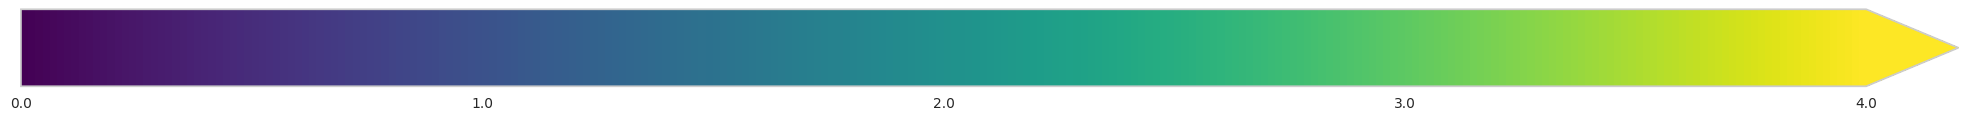

In [24]:
fig, ax = plt.subplots(figsize=(25,1))

cmap = plt.cm.viridis

# Create a scalar mappable for the colorbar
norm = plt.Normalize(0, 4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
sm.set_array([])

# Create the colorbar
cbar = plt.colorbar(sm, orientation='horizontal', cax=ax, extend = 'max')

# Optionally, you can set ticks and labels for the colorbar
cbar.set_ticks(np.linspace(0, 4, 5))
cbar.set_ticklabels([f'{i:.1f}' for i in np.linspace(0, 4, 5)])

plt.savefig('viridis_colorbar.png', bbox_inches='tight')

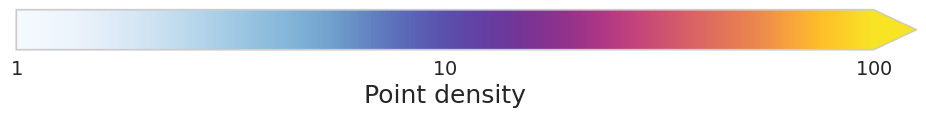

In [28]:
import matplotlib as mpl
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=blended_cmap, extend = 'max', norm=LogNorm(vmin=1, vmax=100))
cb.set_label('Point density', fontsize = 18)
cb.set_ticks([1,10,100])
cb.set_ticklabels(['$1$','$10$','$100$'], fontsize = 14)
cb.set_label('Point density', fontsize = 18)
plt.savefig('density_colormap2.png', bbox_inches='tight', transparent = True, dpi = 300)

In [36]:
elevation = xr.open_dataset('/staging/leuven/stg_00024/OUTPUT/devond/Microwave_practical/elevation.nc')
background = np.zeros(elevation.Elevation_inst.values.shape)

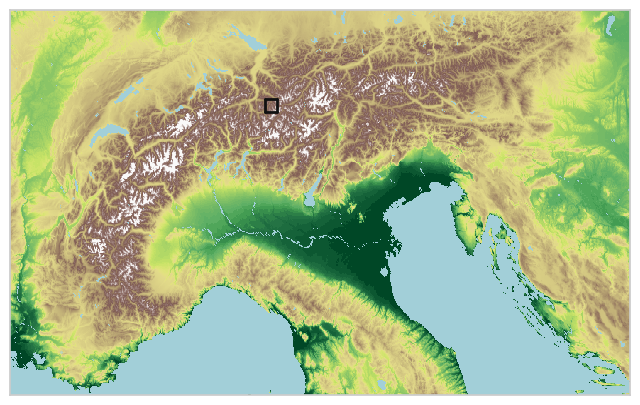

In [38]:
# Example colormaps
cmap1 = plt.cm.ocean_r
cmap2 = plt.cm.summer
cmap3 = plt.cm.terrain

colors1 = cmap1(np.linspace(0.7, 1,10))
colors2 = cmap2(np.linspace(0.25, 0.9, 50))
colors3 = cmap3(np.linspace(0.55, 0.8, 400))
colors4 = cmap3(np.linspace(0.8, 1, 100))
colors = np.vstack((colors1, colors2, colors3, colors4))

x = pd.DataFrame(colors)
x = x.rolling(window = 20, min_periods = 1, center = True).mean()
colors3 = x.values

blended_cmap = LinearSegmentedColormap.from_list('blended_cmap', colors3)

fig, ax = plt.subplots(1,1,figsize = (8,5))
ax.pcolormesh(elevation.lon, elevation.lat, background, cmap = 'Spectral', vmin = -150, vmax = 25, alpha = 0.5)
im1 = ax.pcolormesh(elevation.lon, elevation.lat, elevation.Elevation_inst, cmap = blended_cmap, vmin = -0, vmax = 3000)
plt.plot([9.725,9.725], [46.67,46.84],'k-', linewidth = 2)
plt.plot([9.975,9.975], [46.67,46.84],'k-', linewidth = 2)
plt.plot([9.725,9.975], [46.67,46.67],'k-', linewidth = 2)
plt.plot([9.725,9.975], [46.84,46.84],'k-', linewidth = 2)

#ax[0,3].set_xlim([9.65, 10.1])
#ax[0,3].set_ylim([46.67,46.9])
#im2 = ax.scatter(sites.lon, sites.lat, c = site_ml_bias, cmap = 'RdBu_r', edgecolors = 'k', s = data.groupby(data.site).count().time, vmin = -1, vmax = 1)

#lg.set_title('# Observations', fontsize = 20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([4.505, 17.19])
ax.set_ylim([43,  48.])
plt.savefig('panels/SFig_map.png', dpi = 300, bbox_inches = 'tight')
